In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
from datetime import datetime
import scipy.io as sio
import datetime
from datetime import datetime, timedelta
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
import pickle

In [2]:
def espra(xi, yi, ui, vi):
    from scipy.optimize import least_squares
    if np.any(np.isnan(ui)):
        return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
    def residuals(params, x, y, u_i, v_i):
        x0, y0, q11, q12, q22 = params
        u = -2 * q22 * (y - y0) - 2 * q12 * (x - x0)
        v =  2 * q11 * (x - x0) + 2 * q12 * (y - y0)
        return np.concatenate([(u - u_i), (v - v_i)])
    def fit_params(x, y, u_i, v_i):
        x0_init, y0_init = np.mean(x), np.mean(y)
        q11_init, q12_init, q22_init = 1.0, 0.0, 1.0  # Initial guesses
        params_init = [x0_init, y0_init, q11_init, q12_init, q22_init]
        result = least_squares(residuals, params_init, args=(x, y, u_i, v_i))
        return result.x 
    x0, y0, q11, q12, q22 = fit_params(xi, yi, ui, vi)
    w = 2*(q11 + q22)
    Q = np.array([[q11, q12], [q12, q22]])
    return x0, y0, Q, w

def plot_ellipse(Q, center=(0, 0), scale=1):
    def normalize_matrix(A, norm_type='fro'):
        norm = np.linalg.norm(A, 'fro') if norm_type == 'fro' else np.max(np.abs(A))
        return A / norm if norm else A
    Q = normalize_matrix(Q)

    def swap_principal_axes(Q):
        eigvals, eigvecs = np.linalg.eigh(Q)
        return eigvecs @ np.diag(eigvals[::-1]) @ eigvecs.T

    Q = swap_principal_axes(Q)
    
    eigenvalues, eigenvectors = np.linalg.eigh(Q)
    if np.any(eigenvalues < 0):

        Q = np.array([[np.abs(Q[0,0]), Q[0,1]], [Q[1,0], np.abs(Q[1,1])]])

        def flip_Q_y(Q):
            F_y = np.diag([-1, 1])
            return F_y.T @ Q @ F_y

        Q = flip_Q_y(Q)

        eigenvalues, eigenvectors = np.linalg.eigh(Q)
        if np.any(eigenvalues < 0):
            return np.nan, np.nan
    a, b = np.sqrt(eigenvalues) * scale
    theta = np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0])
    t = np.linspace(0, 2 * np.pi, 100)
    x, y = a * np.cos(t), b * np.sin(t)
    R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    x_ellipse, y_ellipse = R @ np.array([x, y]) + np.array(center).reshape(2, 1)
    return x_ellipse, y_ellipse

#### Drfiter Data

In [3]:
drifter_path = '/srv/scratch/z5297792/IN2023/2023_drifters.nc'
drifter_dataset = nc.Dataset(drifter_path, mode='r')

u_drif, v_drif = drifter_dataset['ve'][:].data/100, drifter_dataset['vn'][:].data/100
lon_drif, lat_drif = drifter_dataset['longitude'][:].data, drifter_dataset['latitude'][:].data
tim_drif, ID_drif = drifter_dataset['time'][:].data, drifter_dataset['ID'][:].data
dt_strings = [b''.join(row).decode('utf-8') for row in tim_drif]
tim_drif = [datetime.fromisoformat(s) for s in dt_strings]
df_drifters = pd.DataFrame({'ID': ID_drif.astype(int), 'Lon': lon_drif, 'Lat': lat_drif, 'u': u_drif, 'v': v_drif, 'Time': tim_drif})
df_drifters

,ID,Lon,Lat,u,v,Time
0,1,155.071686,-37.423271,0.336407,-0.524240,2023-10-23 16:00:00
1,1,155.085403,-37.440243,0.342941,-0.514329,2023-10-23 17:00:00
2,1,155.099655,-37.456573,0.356158,-0.494175,2023-10-23 18:00:00
3,1,155.114456,-37.472240,0.367879,-0.471484,2023-10-23 19:00:00
4,1,155.129669,-37.487103,0.357340,-0.426944,2023-10-23 20:00:00
...,...,...,...,...,...,...
32704,19,157.954788,-33.808270,0.788511,-0.257061,2023-12-30 18:00:00
32705,19,157.985443,-33.815174,0.778468,-0.190267,2023-12-30 19:00:00
32706,19,158.015457,-33.820591,0.769020,-0.143037,2023-12-30 20:00:00
32707,19,158.045380,-33.824436,0.766826,-0.095277,2023-12-30 21:00:00


#### Ship Data

In [4]:
sadcp_data = sio.loadmat('/srv/scratch/z5297792/IN2023/sadcp.mat', simplify_cells=True)

z_sadcp = sadcp_data['z_sadcp']
u_sadcp = pd.DataFrame(sadcp_data['u_sadcp'], index=z_sadcp)
v_sadcp = pd.DataFrame(sadcp_data['v_sadcp'], index=z_sadcp)
lat_sadcp = sadcp_data['lat_sadcp']
lon_sadcp = sadcp_data['lon_sadcp']
tim_sadcp = sadcp_data['tim_sadcp']
julian_dates = tim_sadcp
ref_date = datetime(2000, 1, 1, 12)  # Julian day 2451545.0
gregorian_dates = [ref_date + timedelta(days=jd - 2451545.0) for jd in julian_dates]
tim_sadcp = gregorian_dates

depth = 37
df_sadcp = pd.DataFrame({'Lon': lon_sadcp, 'Lat': lat_sadcp, 'u': u_sadcp.loc[depth], 'v': v_sadcp.loc[depth], 'Time': tim_sadcp})
# df_sadcp.set_index('Time', inplace=True)
df_sadcp

,Lon,Lat,u,v,Time
0,151.320299,-33.889224,0.005571,-0.115798,2023-10-09 11:56:08.499988
1,151.336628,-33.915619,-0.007718,-0.126222,2023-10-09 12:13:38.666652
2,151.372994,-33.939047,-0.006178,-0.136486,2023-10-09 12:26:08.500002
3,151.426511,-33.973251,-0.040717,-0.105075,2023-10-09 12:43:38.666665
4,151.464043,-33.998656,-0.054494,-0.137621,2023-10-09 12:56:08.749984
...,...,...,...,...,...
2169,152.133657,-33.499170,-0.193570,-1.186649,2023-11-01 03:40:29.666685
2170,152.162703,-33.499744,-0.265587,-1.283703,2023-11-01 03:55:29.333340
2171,152.191377,-33.499695,-0.273816,-1.294686,2023-11-01 04:10:29.666658
2172,152.220223,-33.499658,-0.283102,-1.272112,2023-11-01 04:25:29.333353


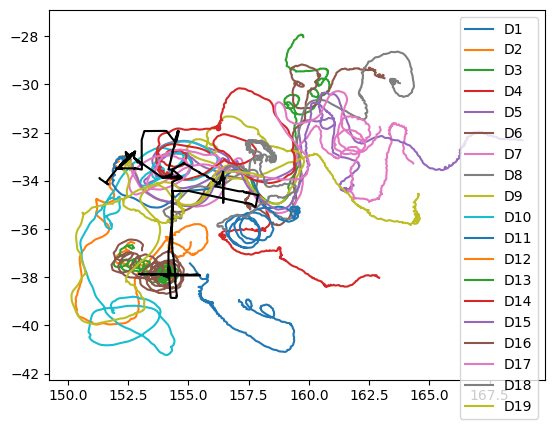

In [5]:
for ID in df_drifters['ID'].unique():

    df_drif = df_drifters[df_drifters['ID']==ID]
    plt.plot(df_drif['Lon'], df_drif['Lat'], label=f'D{ID}')

plt.axis('equal')
plt.legend()

plt.plot(df_sadcp['Lon'], df_sadcp['Lat'], c='k')


In [6]:
df_obs_data = pd.concat([df_drifters, df_sadcp], ignore_index=True, sort=False)
df_obs_data = df_obs_data.sort_values(by='Time').reset_index(drop=True)
# df_obs_data = df_obs_data[df_obs_data['Time'] <= pd.Timestamp('2023-12-10 06:00:00')]
df_obs_data

,ID,Lon,Lat,u,v,Time
0,NaN,151.320299,-33.889224,0.005571,-0.115798,2023-10-09 11:56:08.499988
1,NaN,151.336628,-33.915619,-0.007718,-0.126222,2023-10-09 12:13:38.666652
2,NaN,151.372994,-33.939047,-0.006178,-0.136486,2023-10-09 12:26:08.500002
3,NaN,151.426511,-33.973251,-0.040717,-0.105075,2023-10-09 12:43:38.666665
4,NaN,151.464043,-33.998656,-0.054494,-0.137621,2023-10-09 12:56:08.749984
...,...,...,...,...,...,...
34878,8.0,163.780426,-29.946438,0.223790,-0.060704,2023-12-30 23:00:00.000000
34879,4.0,162.917786,-38.022373,0.095789,0.021097,2023-12-30 23:00:00.000000
34880,6.0,163.140686,-29.742563,0.579057,-0.107962,2023-12-30 23:00:00.000000
34881,7.0,164.334869,-33.275684,0.171763,-0.353148,2023-12-30 23:00:00.000000


#### Satellite Data

In [7]:
ssh_path = '/srv/scratch/z5297792/IN2023/IMOS_aggregation.nc'
ssh_dataset = nc.Dataset(ssh_path, mode='r')
lon_ssh, lat_ssh = ssh_dataset['LONGITUDE'][:].data, ssh_dataset['LATITUDE'][:].data
lon_ssh, lat_ssh = np.meshgrid(lon_ssh, lat_ssh)
u_ssh, v_ssh = ssh_dataset['UCUR'][:].data, ssh_dataset['VCUR'][:].data # TIME, LATITUDE, LONGITUDE
u_ssh, v_ssh = np.transpose(u_ssh, axes=(2,1,0)), np.transpose(v_ssh, axes=(2,1,0)) # LON, LAT, TIME
# u_ssh, v_ssh = np.where(u_ssh > -4, u_ssh, np.nan), np.where(v_ssh > -4, u_ssh, np.nan)
tim_ssh = ssh_dataset['TIME'][:].data # days since 1985-01-01 00:00:00 UTC

ref_date = pd.Timestamp("1985-01-01 00:00:00")
tim_ssh = ref_date + pd.to_timedelta(tim_ssh, unit="D")

(-38.4, -37.4)

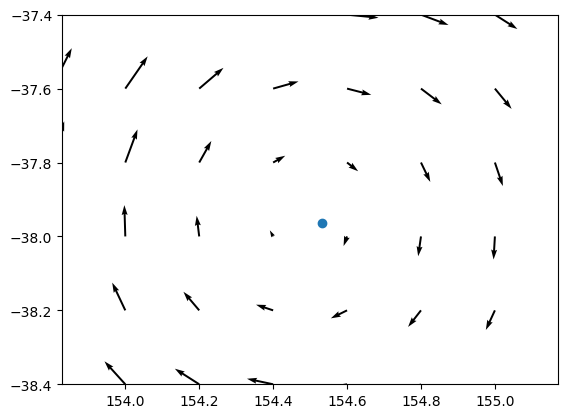

In [9]:
lon_min_CE, lon_max_CE = 154, 155
lat_min_CE, lat_max_CE = -38.4, -37.4

t = 0
ut, vt = u_ssh[:,:,t], v_ssh[:,:,t]
plt.quiver(lon_ssh, lat_ssh, ut.T, vt.T, width=.004, scale=10)

mask = (lon_ssh >= lon_min_CE) & (lon_ssh <= lon_max_CE) & (lat_ssh >= lat_min_CE) & (lat_ssh <= lat_max_CE)
xi, yi, ui, vi = lon_ssh[mask], lat_ssh[mask], ut.T[mask], vt.T[mask]
x0, y0, Q, w = espra(xi, yi, ui, vi)
plt.scatter(x0, y0)

plt.axis('equal')
plt.xlim(lon_min_CE, lon_max_CE)
plt.ylim(lat_min_CE, lat_max_CE)




In [10]:
lon_min_CE, lon_max_CE = 154, 155
lat_min_CE, lat_max_CE = -38.4, -37.4

dic_obs = {}

x0, y0 = np.mean([lon_min_CE, lon_max_CE]), np.mean([lat_min_CE, lat_max_CE])
x0_obs, y0_obs, Q_obs, w_obs = np.nan, np.nan, np.nan, np.nan
df_trace = pd.DataFrame(columns=['x0_SAT', 'y0_SAT', 'Q_SAT', 'w_SAT','x0_OBS', 'y0_OBS', 'Q_OBS', 'w_OBS', 'Time'])
for t, time in enumerate(tim_ssh):
 
    if (x0 < lon_ssh.min()) or (x0 > lon_ssh.max()) or (y0 < lat_ssh.min()) or (y0 > lat_ssh.max()):
        break
    
    ut, vt = u_ssh[:,:,t], v_ssh[:,:,t]
    if t == 0:
        mask = (lon_ssh >= lon_min_CE) & (lon_ssh <= lon_max_CE) & (lat_ssh >= lat_min_CE) & (lat_ssh <= lat_max_CE)
    else:
        mask = np.hypot(x0 - lon_ssh, y0 - lat_ssh) <= .2
    
    xi, yi, ui, vi = lon_ssh[mask], lat_ssh[mask], ut.T[mask], vt.T[mask]
    
    x0_old, y0_old = x0, y0
    x0, y0, Q, w = espra(xi, yi, ui, vi)

    if np.hypot(x0 - x0_old, y0 - y0_old) < 1:
        
        t1 = time - pd.Timedelta(days=0.5)
        t2 = time + pd.Timedelta(days=0.5)

        R = np.hypot(x0 - df_obs_data['Lon'], y0 - df_obs_data['Lat']) < 1
        local_obs_data = df_obs_data[(R) & (df_obs_data['Time'] >= t1) & (df_obs_data['Time'] <= t2)]
        if not local_obs_data.empty:
            xi, yi, ui, vi = local_obs_data['Lon'], local_obs_data['Lat'], local_obs_data['u'], local_obs_data['v'] 
            x0_obs, y0_obs, Q_obs, w_obs = espra(xi, yi, ui, vi)
            
            if np.hypot(x0 - x0_obs, y0 - y0_obs) >= 1:
                x0_obs, y0_obs, Q_obs, w_obs = np.nan, np.nan, np.nan, np.nan
                
        else:
            x0_obs, y0_obs, Q_obs, w_obs = np.nan, np.nan, np.nan, np.nan

        if not np.isnan(x0_obs):
            dic_obs[time] = {'xi': xi, 'yi': yi, 'ui': ui, 'vi': vi}
        
        df_trace.loc[len(df_trace)] = {'x0_SAT': x0, 'y0_SAT': y0, 'Q_SAT': Q, 'w_SAT': w, 
                                               'x0_OBS': x0_obs, 'y0_OBS': y0_obs, 'Q_OBS': Q_obs, 'w_OBS': w_obs,
                                               'Time': time}


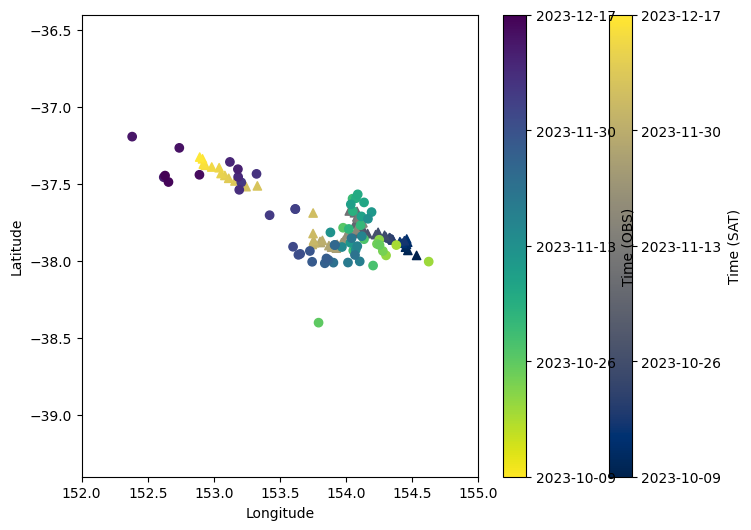

In [29]:
import matplotlib.colors as mcolors

fig, ax = plt.subplots(figsize=(8, 6))

ts_sat = np.array([t.timestamp() for t in df_trace['Time']])
ts_obs = np.array([t.timestamp() for t in df_trace['Time']])

norm = mcolors.Normalize(vmin=ts_sat.min(), vmax=ts_sat.max())

sc1 = ax.scatter(df_trace['x0_SAT'], df_trace['y0_SAT'], c=ts_sat, cmap=plt.cm.cividis, norm=norm, marker='^')
cbar1 = plt.colorbar(sc1, ax=ax, label="Time (SAT)")

sc2 = ax.scatter(df_trace['x0_OBS'], df_trace['y0_OBS'], c=ts_obs, cmap=plt.cm.viridis_r, norm=norm)
cbar2 = plt.colorbar(sc2, ax=ax, label="Time (OBS)")

tick_locs = np.linspace(ts_sat.min(), ts_sat.max(), num=5)
for cbar in [cbar1, cbar2]:
    cbar.set_ticks(tick_locs)
    cbar.set_ticklabels([pd.to_datetime(t, unit='s').strftime('%Y-%m-%d') for t in tick_locs])

ax.set_xlim(lon_min_CE - 2, lon_max_CE)
ax.set_ylim(lat_min_CE - 1, lat_max_CE + 1)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()


In [12]:
df_trace

,x0_SAT,y0_SAT,Q_SAT,w_SAT,x0_OBS,y0_OBS,Q_OBS,w_OBS,Time
0,154.532419,-37.962941,"[[-0.5416575626577694, 0.029117066031543553], ...",-2.191472,NaN,NaN,NaN,NaN,2023-10-09 18:00:00
1,154.466340,-37.930386,"[[-0.6980780329632007, 0.05264319772900968], [...",-2.868692,NaN,NaN,NaN,NaN,2023-10-10 18:00:00
2,154.448446,-37.909527,"[[-0.806986895158862, 0.09231684644359126], [0...",-3.113594,NaN,NaN,NaN,NaN,2023-10-11 18:00:00
3,154.455736,-37.891271,"[[-0.7593039067853671, 0.08077726314573079], [...",-2.972068,NaN,NaN,NaN,NaN,2023-10-12 18:00:00
4,154.464998,-37.877260,"[[-0.761974154137779, 0.055981465302784174], [...",-2.911793,NaN,NaN,NaN,NaN,2023-10-13 18:00:00
...,...,...,...,...,...,...,...,...,...
65,152.983464,-37.388822,"[[-1.3125267727206218, -0.0202188821743513], [...",-4.766333,152.381875,-37.191621,"[[-0.24894008497951273, -0.14361101106227214],...",-1.384812,2023-12-13 06:00:00
66,152.935197,-37.377837,"[[-1.2785738692926487, 0.008774259206265976], ...",-4.616026,152.738253,-37.264621,"[[-0.397158188539917, -0.13621459518894832], [...",-1.565871,2023-12-14 06:00:00
67,152.919988,-37.370133,"[[-1.2510109501475082, -0.0017166967204153174]...",-4.487083,152.890439,-37.439383,"[[-0.46838347957242626, 0.016930859609116725],...",-1.927509,2023-12-15 06:00:00
68,152.913520,-37.335830,"[[-1.2124801214917371, -0.0036241945267624517]...",-4.405443,152.656356,-37.486283,"[[-0.6671159862505022, 0.03916895170264173], [...",-2.623826,2023-12-16 06:00:00


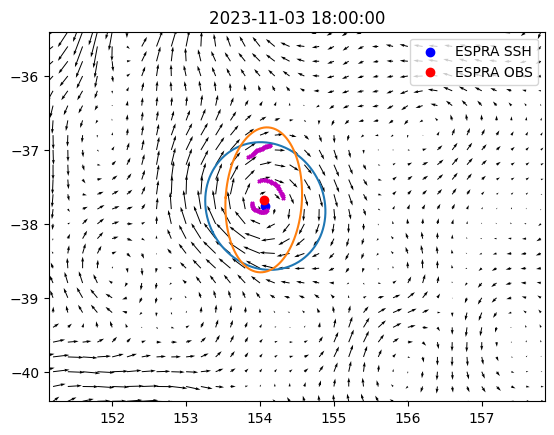

In [18]:
t = 25
time = tim_ssh[t]

ut, vt = u_ssh[:,:,t], v_ssh[:,:,t]
plt.quiver(lon_ssh, lat_ssh, ut.T, vt.T, width=.002, scale=15)

df = df_trace[df_trace['Time']==time]

plt.scatter(df['x0_SAT'], df['y0_SAT'], color='b', label='ESPRA SSH')
x_ellipse, y_ellipse = plot_ellipse(df['Q_SAT'].iloc[0], center=(df['x0_SAT'], df['y0_SAT']), scale=1)
plt.plot(x_ellipse, y_ellipse)

if not np.isnan(df.iloc[0]['x0_OBS']):
    plt.scatter(df['x0_OBS'], df['y0_OBS'], color='r', label='ESPRA OBS')
    x_ellipse, y_ellipse = plot_ellipse(df['Q_OBS'].iloc[0], center=(df['x0_OBS'], df['y0_OBS']), scale=1)
    plt.plot(x_ellipse, y_ellipse)

if time in list(dic_obs.keys()):
    xi, yi = dic_obs[time]['xi'], dic_obs[time]['yi']
    plt.scatter(xi, yi, marker='x', color='m', s=5)

plt.axis('equal')
plt.xlim(lon_min_CE-2, lon_max_CE+2)
plt.ylim(lat_min_CE-2, lat_max_CE+2)

plt.title(f'{time}')

plt.legend()

In [16]:
df_trace.to_pickle("Drifter_plot_data/df_trace.pkl")
with open("Drifter_plot_data/dic_obs.pkl", "wb") as f:
    pickle.dump(dic_obs, f)